Navigation

Everything about the global navigation is done on the computer. Only the motors commands are sent to the Thymio using the tdmclient library.

Functioning :
    The Thymio has two states, moving forward and turning on itself.
    Turning on itself :
        When the Thymio starts its path, it assures to not move forward as long as its angle is not close to the good one. It
        is the same behaviour when the Thymio reaches one of its objectif. One objectif can be either a house (in red) or an 
        edge of a dilated obstacle (in green). The objectif is considered to be reached when the Thymio is in a circular zone 
        around the objectif point. This avoids that the Thymio just go throught its objectif without noticing it and get lost.
        To ensure that the Thymio reaches the good angle easily, its rotation speed decrease when it approaches the right angle
        following the model on the graph below (Figure X)
    Moving forward :
        Whilst the Thymio is between two of its objectifs, it has to follow the straightest line possible. To keep it on good 
        track, a PD regulator is used. This ensure that the Thymio will not go too far of its path.
    Finally, when the Thymio reaches its final objectif, it stops and do not move anymore.

Below is the code of the main loop of the navigation which was precedently explained in the "Functioning" part.



J'ai l'impression que ça sert pas à grand chose de juste expliquer cette partie de code comme ça.... Surtout que j'ai déjà expliqué le tout en gros, dites moi ce que vous en pensez!!

The first "if" is to stop the Thymio when it has finished its course.
in the "else", the first thing done is to adapt the angle received from the kalman (-180,180) in the range of +/- Infinite to the one I work with (0,360).
Then one extract the deprture and the objectif from the list in function of the number of objectif already reached.


In [ ]:
def navigation(pos_r, angle_r, obj_list, prev_err_pos, T, objectif_number, turn):
    if objectif_number==len(obj_list)-1 :
        motors=np.array([0,0])
        turn = False
        return motors, 0, objectif_number, turn
    else:
        angle_r=angle_r%(np.pi*2)
        
        dep, obj=next_obj(obj_list, objectif_number)
        err_pos=error(pos_r, dep, obj)

        if not turn:    
            motors=motors_corr(prev_err_pos, err_pos, dep, obj, pos_r, T)
            reached, objectif_number, turn=reach_obj(pos_r, obj, objectif_number, turn)
            if reached :
                dep, obj=next_obj(obj_list, objectif_number)
                motors, turn = start_angle(angle_r, dep, obj, turn)
        else:
            motors,turn = start_angle(angle_r, dep, obj, turn)


    return motors, err_pos, objectif_number, turn

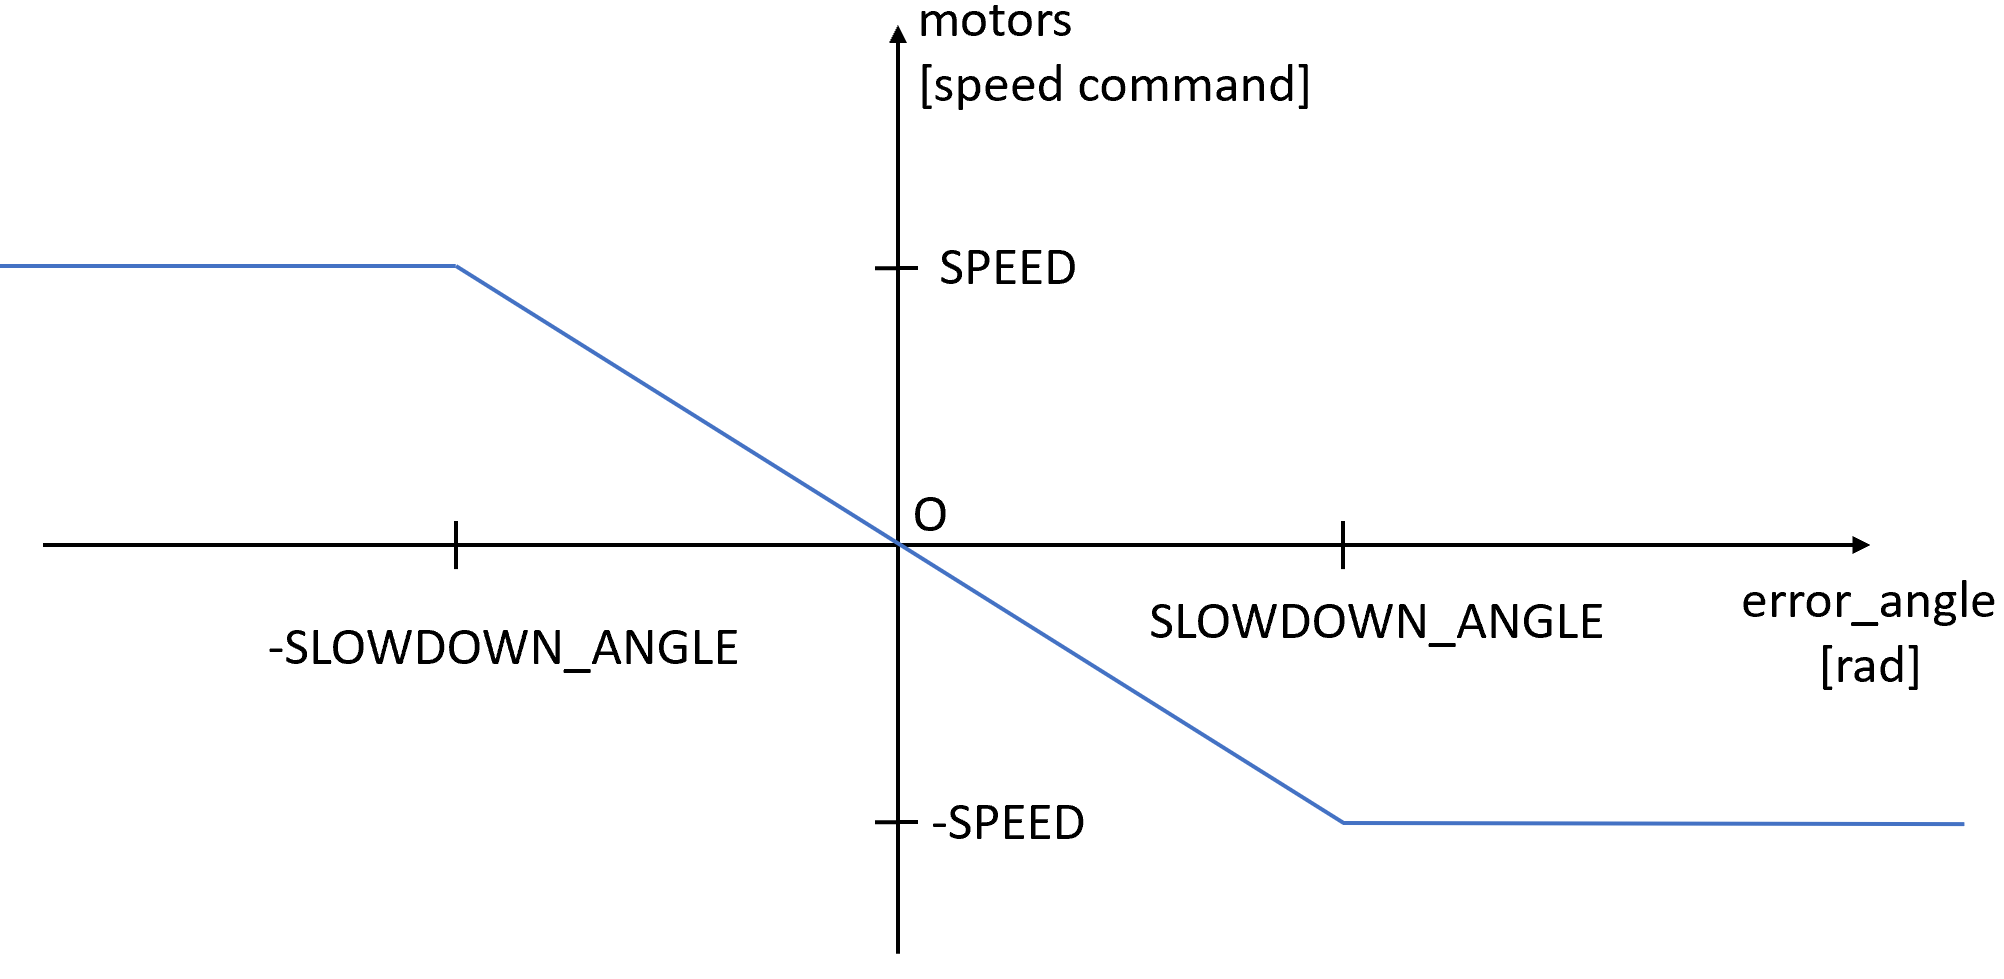

Figure X Speed representation when the error of angles go to zero

The code below is the implementation of the graph on figure X

In [ ]:
#When an objectif is reached, the robot turn on itself until it reaches the good angle.
def start_angle(angle_r, dep, obj, turn):
    angle_dep_obj = angle(dep, obj)
    error_angle = angle_err(angle_r, angle_dep_obj)
    if abs(error_angle) <= THRESHOLD_ANGLE:
        #small error, goes on        
        turn=False
        motors=np.array([SPEED,SPEED])
    else:
        if optimal_side(angle_r, dep, obj):
            #turns left
            motors=np.array([-SPEED,SPEED])
            if abs(error_angle)<SLOWDOWN_ANGLE:
                motors=np.array([int(-SPEED*abs(error_angle)/SLOWDOWN_ANGLE),int(SPEED*abs(error_angle)/SLOWDOWN_ANGLE)])
            
        else:
            #turns right
            motors=np.array([SPEED,-SPEED])
            if abs(error_angle)<SLOWDOWN_ANGLE:
                motors=np.array([int(SPEED*abs(error_angle)/SLOWDOWN_ANGLE),int(-SPEED*abs(error_angle)/SLOWDOWN_ANGLE)])
                
        turn=True
    return motors, turn

The local navigation is directly done on the Thymio and has a higher priority than the commands sent by the computer. It is used to avoid the obstacle on Thymio's path. When the front proximity sensors detect an obstacle, the Thymio will turn according to the value of the sensors until it does not detect the obstacle anymore. After that, the Thymio will continue to move forward for a short time to avoid it to go back in the obstacle because of the PD regulator.
Limitations : If the obstacle is really in the center of the way of the Thymio, it will turn and go too far of its way so that the regulator will not be able to bring the Thymio back on its path.

In [1]:
import tdmclient.notebook
import numpy as np
await tdmclient.notebook.start()

In [2]:
%%run_python
timer_period[0] = 10  # 10ms sampling time
timer=0
@onevent 
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, timer
    SPEED=100
    PROX_FACTOR=80
    THRESHOLD_PROX=50
    if prox_horizontal[0]>THRESHOLD_PROX or prox_horizontal[1]>THRESHOLD_PROX:
        #Should turn right
        motor_left_target=(SPEED+prox_horizontal[0]//PROX_FACTOR+prox_horizontal[1]//PROX_FACTOR)
        motor_right_target=(SPEED-prox_horizontal[0]//PROX_FACTOR-prox_horizontal[1]//PROX_FACTOR)
        timer=200
    elif prox_horizontal[4]>THRESHOLD_PROX :
        #Should turn left
        motor_left_target=(SPEED-prox_horizontal[4]//PROX_FACTOR-prox_horizontal[3]//PROX_FACTOR)
        motor_right_target=(SPEED+prox_horizontal[4]//PROX_FACTOR+prox_horizontal[3]//PROX_FACTOR)
        timer=200
    elif prox_horizontal[3]>THRESHOLD_PROX:
        #Should turn left
        motor_left_target=(SPEED-prox_horizontal[4]//PROX_FACTOR-prox_horizontal[3]//PROX_FACTOR)
        motor_right_target=(SPEED+prox_horizontal[4]//PROX_FACTOR+prox_horizontal[3]//PROX_FACTOR)
        timer=200
    else:
        if timer>0:
            timer=timer-1
            motor_left_target=SPEED
            motor_right_target=SPEED
        else:
            timer=0
    
@onevent
def button_center():
    global motor_left_target, motor_right_target
    motor_left_target=0
    motor_right_target=0

In [3]:
await tdmclient.notebook.stop()